In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import cv2
import os
import pickle
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [18]:
class MasterImage(object):

    def __init__(self, PATH='', IMAGE_SIZE=50):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE
        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories:", self.list_categories)
        return self.list_categories
    
    def process_image(self):
        try:
            self.CATEGORIES = self.get_categories()
            for category in self.CATEGORIES:
                train_folder_path = os.path.join(self.PATH, category)
                class_index = self.CATEGORIES.index(category)
                for img in os.listdir(train_folder_path):
                    image_path = os.path.join(train_folder_path, img)
                    try:
                        image_data_temp = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        image_temp_resize = cv2.resize(image_data_temp, (self.IMAGE_SIZE, self.IMAGE_SIZE))
                        self.image_data.append((image_temp_resize, class_index))
                    except:
                        pass
            self.image_data = [data for data in self.image_data if data[0] is not None]

            X_Data = []
            Y_Data = []
            for img, label in self.image_data:
                X_Data.append(img)
                Y_Data.append(label)

            X_Data = np.asarray(X_Data) / 255.0
            Y_Data = np.asarray(Y_Data)
            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)

            return X_Data, Y_Data
        except Exception as e:
            print("Failed to run Function process_image:", e)

    def pickle_image(self):
        try:
            X_Data, Y_Data = self.process_image()

            with open('X_Data.pickle', 'wb') as pickle_out:
                pickle.dump(X_Data, pickle_out)

            with open('Y_Data.pickle', 'wb') as pickle_out:
                pickle.dump(Y_Data, pickle_out)

            print("Pickle files created successfully.")
            return X_Data, Y_Data
        except Exception as e:
            print("Failed to create pickle files:", e)

    def load_dataset(self):
        try:
            if os.path.exists('X_Data.pickle') and os.path.exists('Y_Data.pickle'):
                with open('X_Data.pickle', 'rb') as pickle_in:
                    X_Data = pickle.load(pickle_in)

                with open('Y_Data.pickle', 'rb') as pickle_in:
                    Y_Data = pickle.load(pickle_in)

                print('Dataset loaded from pickle files.')
                return X_Data, Y_Data
            else:
                print('Pickle files not found.')
                print('Creating pickle files and loading the dataset...')
                X_Data, Y_Data = self.pickle_image()
                return X_Data, Y_Data
        except Exception as e:
            print("Failed to load dataset:", e)



In [19]:
path = 'separated_data'
a = MasterImage(PATH=path, IMAGE_SIZE=80)
X_Data, Y_Data = a.load_dataset()

Dataset loaded from pickle files.


In [20]:
# Split the scaled data into train, validation, and test sets
X_train , X_test , y_train , y_test  = train_test_split(X_Data, Y_Data, test_size=0.2, random_state=42)
X_train , X_val , y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Print the shape of each dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7032, 80, 80, 1)
Shape of y_train: (7032, 8)
Shape of X_val: (2344, 80, 80, 1)
Shape of y_val: (2344, 8)
Shape of X_test: (2344, 80, 80, 1)
Shape of y_test: (2344, 8)


In [21]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/30
220/220 [==============================] - 24s 102ms/step - loss: 1.3483 - accuracy: 0.6462 - val_loss: 1.1823 - val_accuracy: 0.6523
Epoch 2/30
220/220 [==============================] - 22s 101ms/step - loss: 1.1713 - accuracy: 0.6615 - val_loss: 1.1029 - val_accuracy: 0.6523
Epoch 3/30
220/220 [==============================] - 24s 111ms/step - loss: 1.1371 - accuracy: 0.6620 - val_loss: 1.0802 - val_accuracy: 0.6523
Epoch 4/30
220/220 [==============================] - 27s 121ms/step - loss: 1.0899 - accuracy: 0.6620 - val_loss: 1.0749 - val_accuracy: 0.6523
Epoch 5/30
220/220 [==============================] - 23s 106ms/step - loss: 1.0780 - accuracy: 0.6637 - val_loss: 1.0208 - val_accuracy: 0.6523
Epoch 6/30
220/220 [==============================] - 24s 107ms/step - loss: 1.0403 - accuracy: 0.6664 - val_loss: 1.0151 - val_accuracy: 0.6523
Epoch 7/30
220/220 [==============================] - 24s 108ms/step - loss: 1.0185 - accuracy: 0.6674 - val_loss: 1.0512 - val_ac

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 18, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 128)        

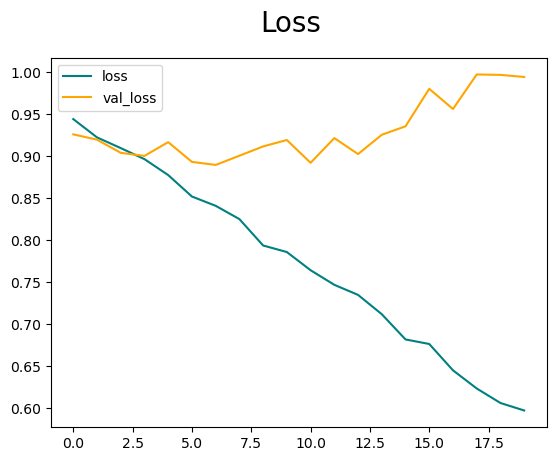

In [23]:
#Plot Performance


fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

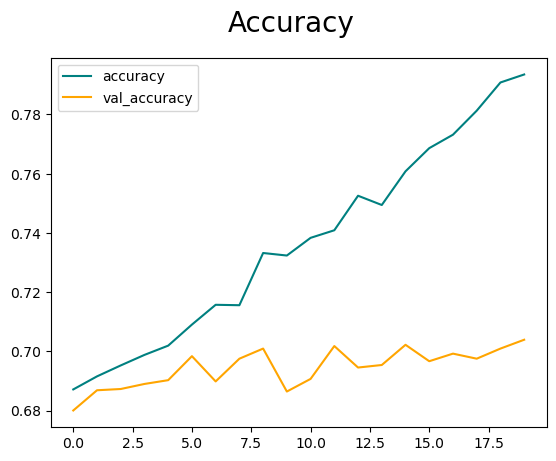

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()